In [1]:
################################################
## setup to use GPU TensorFlow on Colab -- cwr
################################################

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()

#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  print('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import PIL
import numpy as np
from PIL import Image
from os import listdir
from os.path import join
from numpy import asarray
from matplotlib import image
import matplotlib.pyplot as plt

# from DLAVA, includes unused symbols, maybe tighten later
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# trying to get around memory limits:
from random import sample

# 20211128 temp?
from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')


In [3]:
####################
##  temp sandbox  ##
####################

def debug_print(expression):
    print(expression, '=', eval(expression))

# debug_print('1 + 2')
# q = 5
# debug_print('q * 3')

# debug_print('np.array([])')
# debug_print('type(np.array([]))')
# debug_print('np.array([]).shape')
# print()

a = np.empty((0, 2, 2, 2), int)
two_two = np.array([[1, 2], [3, 4]])
two_two_two = np.array([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])

debug_print('two_two.shape')
debug_print('two_two_two.shape')

debug_print('a.shape')
a = np.append(a, [two_two_two], axis=0)
debug_print('a.shape')
a = np.append(a, [two_two_two], axis=0)
debug_print('a.shape')
a = np.append(a, [two_two_two], axis=0)
debug_print('a.shape')
a = np.append(a, [two_two_two], axis=0)
debug_print('a.shape')


two_two.shape = (2, 2)
two_two_two.shape = (2, 2, 2)
a.shape = (0, 2, 2, 2)
a.shape = (1, 2, 2, 2)
a.shape = (2, 2, 2, 2)
a.shape = (3, 2, 2, 2)
a.shape = (4, 2, 2, 2)


In [4]:
# Use the "mini" training set with 9 images.
# fcd_ts_dir = '/content/drive/My Drive/PredatorEye/mini_training_set/'

# Use the "real" training set with 2008 images
fcd_ts_dir = '/content/drive/My Drive/PredatorEye/fcd_training_set/'

# max_input_images = 10
max_input_images = 200
# max_input_images = 300

# fcd_images = []
# fcd_labels = []

# Maybe read from image file?
# Maybe assert all images are square and this size?
fcd_image_size = 1024

# 20211129 change to start empty but with pre-defined shape for appending slices
# n square RGB images so:  n X fcd_image_size X fcd_image_size X 3
# fcd_images_new = np.empty((0, fcd_image_size, fcd_image_size, 3), float)
fcd_images_new = np.empty((0, fcd_image_size, fcd_image_size, 3), np.float32)


fcd_labels = []


random_seed = 20211129
np.random.seed(random_seed)

In [5]:
# Parse FCD filename to a list of (x, y) pixel coordinates.
def fcd_filename_to_xy_pair(filename):
    without_extension = filename.split('.')[0]
    two_numeric_strings = without_extension.split('_')[1:3]
    two_ints = list(map(int, two_numeric_strings))
    return two_ints

In [6]:
# Prototype function to load FCD data from directory pathname

# Get image label from image file names ([x, y] as floats on [0,1])
def fcd_normalized_xy(filename, pixels):
    pixel_coordinates = fcd_filename_to_xy_pair(filename)
    normalized = [pixel_coordinates[0] / pixels.shape[0],
                  pixel_coordinates[1] / pixels.shape[1]]
    return normalized

# Show image from given filename in log.
# (When called this has already been read in. Pass in numpy data array?
def show_image_from_pathname(image_pathname):
  plt.imshow(image.imread(image_pathname))
  plt.show()

def read_fcd_data_from_directory(directory_pathname):
    directory_contents = listdir(directory_pathname)
    # Avoid memory limits, read max_input_images of 2000 images:
    directory_contents = sample(directory_contents, max_input_images)
    for filename in directory_contents:
        image_pathname = join(directory_pathname, filename)
        # Numpy pixel array of image object.
        # pixels = asarray(Image.open(join(directory_pathname, filename)))
        pixels = asarray(Image.open(image_pathname))
        # Accumulate: numpy pixel array of image object.
        #
        # fcd_images.append(pixels)
        # fcd_images_new = np.append(fcd_images_new, [pixels], axis=0)
        # foo = fcd_images_new;
        # fcd_images_new = np.append(foo, [pixels], axis=0)
        #
        # Convert input image data to floating-point.
        pixels = keras_backend.cast_to_floatx(pixels)
        # Scale input image data to range [0, 1] (in DLAVA was [-1, 1])
        pixels = np.interp(pixels, [0, 255], [0, 1])
        # Append this pixel data as a new slice at the end of fcd_images.
        global fcd_images_new
        fcd_images_new = np.append(fcd_images_new, [pixels], axis=0)
        #
        # Accumulate: disk center XY position ground truth.
        fcd_labels.append(np.array(fcd_normalized_xy(filename, pixels)))
        # Progress report (runs for about 6 minutes on 20211127)
        # if ((len(fcd_images) % 50) == 1):
        #     show_image_from_pathname(image_pathname)
        # count = fcd_images_new.shape[0]
        # if ((count % 50) == 1):
        #     show_image_from_pathname(image_pathname)
        #     print(count, "images...")
        if ((fcd_images_read() % 50) == 1):
            show_image_from_pathname(image_pathname)
            print(fcd_images_read(), "images...")
        debug_print('fcd_images_new.shape')

def fcd_images_read():
    return fcd_images_new.shape[0]

In [7]:
# Construct a striding CNN Keras model (cribbed from DLAVA chapter B3, Listing
# B3-41): currently 2 Conv2D with dropout, then 2 dense, outpu layer is dense
# with just two neurons, to generate an XY position estimate for the disk.

def make_striding_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', padding='same',
                     strides=(2, 2), kernel_constraint=MaxNorm(3),
                     # input_shape=(image_height, image_width, 1)))
                     input_shape=(fcd_image_size, fcd_image_size, 3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                     strides=(2, 2), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #
    # instead of softmax, maybe a Dense layer with two neurons (x, y)?
    #
    # model.add(Dense(number_of_classes, activation='softmax'))
    # Just guessing here:
    model.add(Dense(2, activation='relu'))
    #
    # Use MSE in place of categorical_crossentropy
    # since my problem is more like regression
    #
    # model.compile(loss='categorical_crossentropy', optimizer='adam', 
    #               metrics=["accuracy"])
    # model.compile(loss=tf.keras.losses.MeanSquaredError(),
    #               optimizer='adam',
    #               metrics=["accuracy"])
    #
    # 20211128 following example from here:
    # https://stackoverflow.com/q/55884849/1991373
    #
    # model.compile(loss=[tf.keras.losses.MeanSquaredError(),
    #                     tf.keras.losses.MeanSquaredError()],
    #               optimizer='adam',
    #               metrics=["accuracy"])
    # model.compile(loss=['mse', 'mse'],
    #               optimizer='adam',
    #               metrics=["accuracy"])
    model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
    # model.compile(loss=['mse', 'mse'], optimizer='adam', metrics=["accuracy"])
    return model

In [8]:
# Utility to fit and plot a run, again cribbed from DLAVA chapter B3.
def run_model(model_maker, plot_title):
    model = model_maker()
    np.random.seed(random_seed)
    history = model.fit(X_train, y_train,
                        validation_split=0.25,
                        # epochs=100, batch_size=256) ####################
                        epochs=100, batch_size=10)
    plot_accuracy_and_loss(history, plot_title)
    return history

# A little utility to draw plots of accuracy and loss.
def plot_accuracy_and_loss(history, plot_title):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    plt.show()

Reading 200 images from /content/drive/My Drive/PredatorEye/fcd_training_set/
...


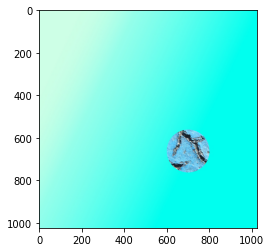

1 images...
fcd_images_new.shape = (1, 1024, 1024, 3)
fcd_images_new.shape = (2, 1024, 1024, 3)
fcd_images_new.shape = (3, 1024, 1024, 3)
fcd_images_new.shape = (4, 1024, 1024, 3)
fcd_images_new.shape = (5, 1024, 1024, 3)
fcd_images_new.shape = (6, 1024, 1024, 3)
fcd_images_new.shape = (7, 1024, 1024, 3)
fcd_images_new.shape = (8, 1024, 1024, 3)
fcd_images_new.shape = (9, 1024, 1024, 3)
fcd_images_new.shape = (10, 1024, 1024, 3)
fcd_images_new.shape = (11, 1024, 1024, 3)
fcd_images_new.shape = (12, 1024, 1024, 3)
fcd_images_new.shape = (13, 1024, 1024, 3)
fcd_images_new.shape = (14, 1024, 1024, 3)
fcd_images_new.shape = (15, 1024, 1024, 3)
fcd_images_new.shape = (16, 1024, 1024, 3)
fcd_images_new.shape = (17, 1024, 1024, 3)
fcd_images_new.shape = (18, 1024, 1024, 3)
fcd_images_new.shape = (19, 1024, 1024, 3)
fcd_images_new.shape = (20, 1024, 1024, 3)
fcd_images_new.shape = (21, 1024, 1024, 3)
fcd_images_new.shape = (22, 1024, 1024, 3)
fcd_images_new.shape = (23, 1024, 1024, 3)
fcd_imag

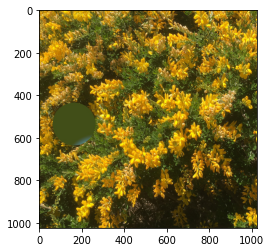

51 images...
fcd_images_new.shape = (51, 1024, 1024, 3)
fcd_images_new.shape = (52, 1024, 1024, 3)
fcd_images_new.shape = (53, 1024, 1024, 3)
fcd_images_new.shape = (54, 1024, 1024, 3)
fcd_images_new.shape = (55, 1024, 1024, 3)
fcd_images_new.shape = (56, 1024, 1024, 3)
fcd_images_new.shape = (57, 1024, 1024, 3)
fcd_images_new.shape = (58, 1024, 1024, 3)
fcd_images_new.shape = (59, 1024, 1024, 3)
fcd_images_new.shape = (60, 1024, 1024, 3)
fcd_images_new.shape = (61, 1024, 1024, 3)
fcd_images_new.shape = (62, 1024, 1024, 3)
fcd_images_new.shape = (63, 1024, 1024, 3)
fcd_images_new.shape = (64, 1024, 1024, 3)
fcd_images_new.shape = (65, 1024, 1024, 3)
fcd_images_new.shape = (66, 1024, 1024, 3)
fcd_images_new.shape = (67, 1024, 1024, 3)
fcd_images_new.shape = (68, 1024, 1024, 3)
fcd_images_new.shape = (69, 1024, 1024, 3)
fcd_images_new.shape = (70, 1024, 1024, 3)
fcd_images_new.shape = (71, 1024, 1024, 3)
fcd_images_new.shape = (72, 1024, 1024, 3)
fcd_images_new.shape = (73, 1024, 1024, 3

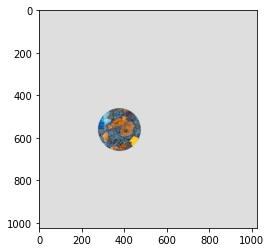

101 images...
fcd_images_new.shape = (101, 1024, 1024, 3)
fcd_images_new.shape = (102, 1024, 1024, 3)
fcd_images_new.shape = (103, 1024, 1024, 3)
fcd_images_new.shape = (104, 1024, 1024, 3)
fcd_images_new.shape = (105, 1024, 1024, 3)
fcd_images_new.shape = (106, 1024, 1024, 3)
fcd_images_new.shape = (107, 1024, 1024, 3)
fcd_images_new.shape = (108, 1024, 1024, 3)
fcd_images_new.shape = (109, 1024, 1024, 3)
fcd_images_new.shape = (110, 1024, 1024, 3)
fcd_images_new.shape = (111, 1024, 1024, 3)
fcd_images_new.shape = (112, 1024, 1024, 3)
fcd_images_new.shape = (113, 1024, 1024, 3)
fcd_images_new.shape = (114, 1024, 1024, 3)
fcd_images_new.shape = (115, 1024, 1024, 3)
fcd_images_new.shape = (116, 1024, 1024, 3)
fcd_images_new.shape = (117, 1024, 1024, 3)
fcd_images_new.shape = (118, 1024, 1024, 3)
fcd_images_new.shape = (119, 1024, 1024, 3)
fcd_images_new.shape = (120, 1024, 1024, 3)
fcd_images_new.shape = (121, 1024, 1024, 3)
fcd_images_new.shape = (122, 1024, 1024, 3)
fcd_images_new.sha

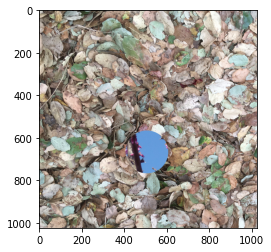

151 images...
fcd_images_new.shape = (151, 1024, 1024, 3)
fcd_images_new.shape = (152, 1024, 1024, 3)
fcd_images_new.shape = (153, 1024, 1024, 3)
fcd_images_new.shape = (154, 1024, 1024, 3)
fcd_images_new.shape = (155, 1024, 1024, 3)
fcd_images_new.shape = (156, 1024, 1024, 3)
fcd_images_new.shape = (157, 1024, 1024, 3)
fcd_images_new.shape = (158, 1024, 1024, 3)
fcd_images_new.shape = (159, 1024, 1024, 3)
fcd_images_new.shape = (160, 1024, 1024, 3)
fcd_images_new.shape = (161, 1024, 1024, 3)
fcd_images_new.shape = (162, 1024, 1024, 3)
fcd_images_new.shape = (163, 1024, 1024, 3)
fcd_images_new.shape = (164, 1024, 1024, 3)
fcd_images_new.shape = (165, 1024, 1024, 3)
fcd_images_new.shape = (166, 1024, 1024, 3)
fcd_images_new.shape = (167, 1024, 1024, 3)
fcd_images_new.shape = (168, 1024, 1024, 3)
fcd_images_new.shape = (169, 1024, 1024, 3)
fcd_images_new.shape = (170, 1024, 1024, 3)
fcd_images_new.shape = (171, 1024, 1024, 3)
fcd_images_new.shape = (172, 1024, 1024, 3)
fcd_images_new.sha

In [9]:
# Read FCD training data from a given directory.
np.random.seed(random_seed)
print('Reading', max_input_images, 'images from ' + fcd_ts_dir)
print('...')
read_fcd_data_from_directory(fcd_ts_dir)
# print('Read', len(fcd_images), 'training images.')
print('Read', fcd_images_read(), 'training images.')

In [10]:
# Pre-process input image data.

# X_train = np.array(fcd_images)
y_train = np.array(fcd_labels)

# print(type(X_train))
# print(X_train.shape)
# print(y_train.shape)
# print()

# print('Before: X_train[0, 0, 0, 0] =', X_train[0, 0, 0, 0])
# # Convert input image data to floating-point.
# X_train = keras_backend.cast_to_floatx(X_train)
# # Scale input image data to range [0, 1] (in DLAVA was [-1, 1])
# X_train = np.interp(X_train, [0, 255], [0, 1])
# print('After:  X_train[0, 0, 0, 0] =', X_train[0, 0, 0, 0])
# print()

# print('y_train[0, :] =', y_train[0, :])
# print('X_train[0, :, :, :] =')
# print(X_train[0, :, :, :])

X_train = fcd_images_new
#y_train = fcd_labels

In [11]:
# Run a model.
striding_history = run_model(make_striding_cnn_model, 'FCD: Striding CNN')

Epoch 1/100
15/15 [==============================] - 18s 477ms/step - loss: 4244.5605 - accuracy: 0.4933 - val_loss: 0.3223 - val_accuracy: 0.5400
Epoch 2/100
15/15 [==============================] - 5s 357ms/step - loss: 0.2931 - accuracy: 0.4933 - val_loss: 0.3223 - val_accuracy: 0.5400
Epoch 3/100
15/15 [==============================] - 5s 363ms/step - loss: 0.2931 - accuracy: 0.4933 - val_loss: 0.3223 - val_accuracy: 0.5400
Epoch 4/100
15/15 [==============================] - 5s 355ms/step - loss: 0.2931 - accuracy: 0.4933 - val_loss: 0.3223 - val_accuracy: 0.5400
Epoch 5/100
15/15 [==============================] - 5s 354ms/step - loss: 0.2931 - accuracy: 0.4933 - val_loss: 0.3223 - val_accuracy: 0.5400
Epoch 6/100
15/15 [==============================] - 5s 366ms/step - loss: 0.2931 - accuracy: 0.4933 - val_loss: 0.3223 - val_accuracy: 0.5400
Epoch 7/100
15/15 [==============================] - 5s 355ms/step - loss: 0.2931 - accuracy: 0.4933 - val_loss: 0.3223 - val_accuracy: 0.

KeyboardInterrupt: ignored